# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

# For visualization
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
# Load datasets (adjust the file paths accordingly)
movies = pd.read_csv('movie.csv')
ratings = pd.read_csv('rating.csv')

# Merge movies and ratings datasets
data = pd.merge(ratings, movies, on='movieId')

# Quick check of the merged dataset
print(data.head())

   userId  movieId  rating            timestamp           title  \
0       1        2     3.5  2005-04-02 23:53:47  Jumanji (1995)   
1       5        2     3.0  1996-12-25 15:26:09  Jumanji (1995)   
2      13        2     3.0  1996-11-27 08:19:02  Jumanji (1995)   
3      29        2     3.0  1996-06-23 20:36:14  Jumanji (1995)   
4      34        2     3.0  1996-10-28 13:29:44  Jumanji (1995)   

                       genres  
0  Adventure|Children|Fantasy  
1  Adventure|Children|Fantasy  
2  Adventure|Children|Fantasy  
3  Adventure|Children|Fantasy  
4  Adventure|Children|Fantasy  


# EDA

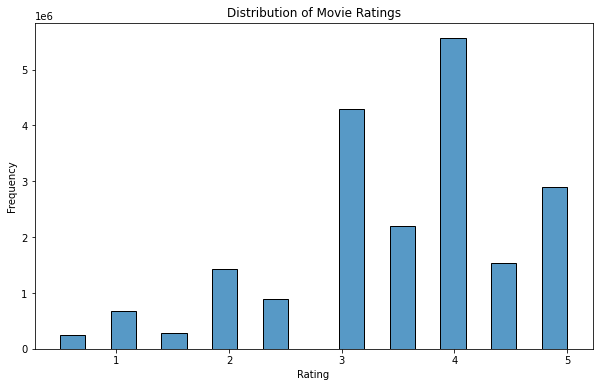

Top 10 Most Rated Movies:
 title
Pulp Fiction (1994)                          67310
Forrest Gump (1994)                          66172
Shawshank Redemption, The (1994)             63366
Silence of the Lambs, The (1991)             63299
Jurassic Park (1993)                         59715
Star Wars: Episode IV - A New Hope (1977)    54502
Braveheart (1995)                            53769
Terminator 2: Judgment Day (1991)            52244
Matrix, The (1999)                           51334
Schindler's List (1993)                      50054
dtype: int64


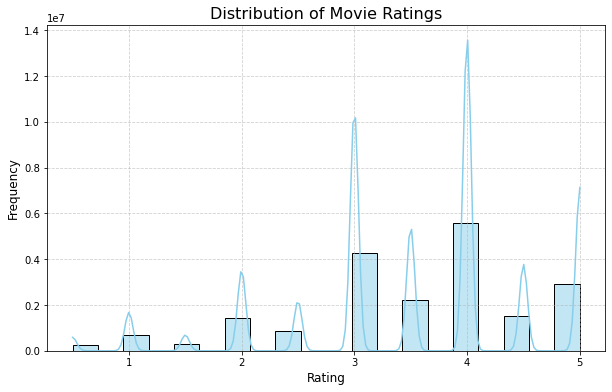

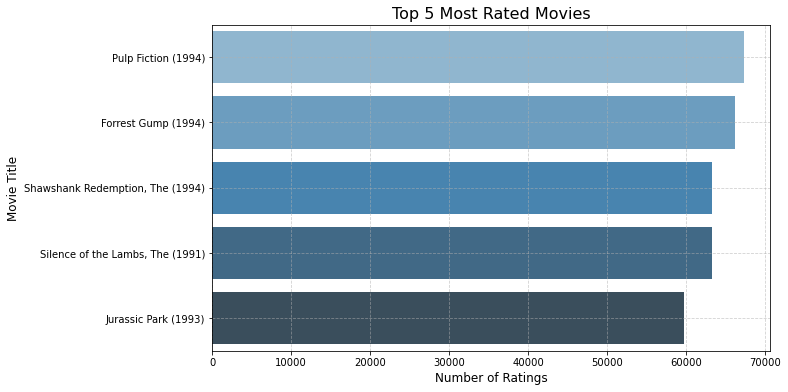

In [6]:
# Movie ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=20, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

# Top-rated movies by count of ratings
top_rated = data.groupby('title').size().sort_values(ascending=False)[:10]
print("Top 10 Most Rated Movies:\n", top_rated)

# Movie Ratings Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(data['rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Top-rated movies by count of ratings
top_rated = data.groupby('title').size().sort_values(ascending=False)[:5]

# Bar plot for top-rated movies
plt.figure(figsize=(10, 6))
sns.barplot(x=top_rated.values, y=top_rated.index, palette="Blues_d")
plt.title('Top 5 Most Rated Movies', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Movie Title', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Collaborative Filtering Model

In [4]:
# Step 1: Remove any duplicate rows (if they exist)
data.drop_duplicates(subset=['userId', 'title'], inplace=True)

# Step 2: Handle multiple ratings by the same user for the same movie by taking the mean rating
data = data.groupby(['userId', 'title'], as_index=False).agg({'rating': 'mean'})

# Step 3: Now create the pivot table (userId x title matrix)
ratings_pivot = data.pivot(index='userId', columns='title', values='rating')

# Fill NaN values with 0 (or use another imputation strategy)
ratings_pivot.fillna(0, inplace=True)

# Apply NearestNeighbors algorithm to find similar users or movies
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(ratings_pivot.values)

# Test the model by finding nearest neighbors for a random user
random_user_id = np.random.choice(ratings_pivot.index)
distances, indices = model_knn.kneighbors(ratings_pivot.iloc[random_user_id, :].values.reshape(1, -1), n_neighbors=5)

# Display similar users/movies
print("Recommendations for user:", random_user_id)
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f"User {random_user_id}'s own preferences:")
    else:
        print(f"{i}: Movie {ratings_pivot.index[indices.flatten()[i]]} with distance: {distances.flatten()[i]}")

Recommendations for user: 94600
User 94600's own preferences:
1: Movie 76120 with distance: 0.7542573540845952
2: Movie 34981 with distance: 0.7720996679383472
3: Movie 124807 with distance: 0.7761166388936075
4: Movie 88378 with distance: 0.7774042444739089


# Content-Based Filtering Using NLP

In [8]:
# Step 1: Prepare the metadata (combine relevant features if necessary)
# For simplicity, we're using only the 'genres' column as the metadata for now
movies_metadata = movies[['title', 'genres']].drop_duplicates().reset_index(drop=True)

# Step 2: Apply TF-IDF Vectorizer to the 'genres' column
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_metadata['genres'])

# Step 3: Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 4: Make sure the titles are lowercase for case-insensitive matching
movies_metadata['title'] = movies_metadata['title'].str.lower()

# Step 5: Define the content-based recommendation function
def content_based_recommendations(title, cosine_sim=cosine_sim):
    # Convert the input title to lowercase for matching
    title = title.lower()
    
    # Find the index of the movie in the dataframe
    idx = movies_metadata.index[movies_metadata['title'] == title]
    
    if len(idx) == 0:
        return "Movie not found in the dataset"
    
    idx = idx[0]  # Get the index of the first match

    # Calculate similarity scores for the input movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the indices of the most similar movies (excluding the input movie itself)
    sim_scores = sim_scores[1:6]  # Get top 5 most similar movies
    movie_indices = [i[0] for i in sim_scores]
    
    return movies_metadata['title'].iloc[movie_indices]

# Step 6: Test the content-based recommender with a movie title
print(content_based_recommendations('Jumanji (1995)'))

55                 kids of the round table (1995)
59             indian in the cupboard, the (1995)
124             neverending story iii, the (1994)
990               escape to witch mountain (1975)
1959    darby o'gill and the little people (1959)
Name: title, dtype: object
